In [1]:
from mylib.statistic_test import *
from mazepy.datastruc.neuact import NeuralTrajectory, SpikeTrain
from mazepy.datastruc.variables import VariableBin
from mylib.calcium.dsp_ms import classify_lap
from mazepy.basic._time_sync import _coordinate_recording_time

code_id = "0855 - Mapping Initialization Phase"
loc = os.path.join(figpath, "Dsp", code_id)
mkdir(loc)

import scipy.stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

dir_name1 = join(figpath, "Dsp", "0850 - Lisa Paper Revisits")
dir_name0 = join(figpath, "Dsp", "0844 - Manifold of Initialization")

def get_neural_traj(trace: dict):    
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx, end_idx = LapSplit(trace, trace['paradigm'])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx)
    
    neural_trajs = []
    pos_trajs = []
    time_trajs = []
    cumlen_trajs = []
    route_trajs = []
    lap_trajs = []
    speed_trajs = []
    perfect_trajs = []
    
    for i in tqdm(range(beg_idx.shape[0])):
        spike_idx = np.where(
            (trace['ms_time'] >= beg_time[i]) & (trace['ms_time'] <= end_time[i]) &
            (np.isnan(trace['spike_nodes_original']) == False)
        )[0]
        
        dx = np.ediff1d(trace['correct_pos'][beg_idx[i]:end_idx[i], 0])/10
        dy = np.ediff1d(trace['correct_pos'][beg_idx[i]:end_idx[i], 1])/10
        dis = np.sqrt(dx**2+dy**2)
        dt = np.ediff1d(trace['correct_time'][beg_idx[i]:end_idx[i]])
        cumdis = np.cumsum(dis)
        
        speed = np.sqrt(dx**2+dy**2) / dt * 1000
        speed = np.convolve(speed, np.ones(3)/3, mode='same')
        cumt = np.cumsum(dt) + trace['correct_time'][beg_idx[i]]
        spike_nodes = trace['spike_nodes_original'][spike_idx].astype(np.int64)-1
        Spikes = trace['Spikes_original'][:, spike_idx]
        
        spike_train = SpikeTrain(
            activity=Spikes,
            time=trace['ms_time'][spike_idx],
            variable=VariableBin(spike_nodes),
        )
        
        neural_traj = spike_train.calc_neural_trajectory(500, 100)
        neural_traj_vec = neural_traj.to_array()
        pos_traj = neural_traj.variable.to_array()
        time_traj = neural_traj.time
        idx = _coordinate_recording_time(time_traj.astype(np.float64), cumt.astype(np.float64))
        
        neural_trajs.append(neural_traj_vec)
        pos_trajs.append(pos_traj)
        time_trajs.append(time_traj - trace['ms_time'][spike_idx[0]])
        speed_trajs.append(speed[idx])
        cumlen_trajs.append(cumdis[idx])
        
        route_trajs.append(np.repeat(routes[i], neural_traj_vec.shape[1]).astype(np.int64))
        lap_trajs.append(np.repeat(i, neural_traj_vec.shape[1]).astype(np.int64))
        perfect_trajs.append(np.repeat(int(trace['is_perfect'][i]), neural_traj_vec.shape[1]))
    
    return (
        np.concatenate(neural_trajs, axis=1), 
        np.concatenate(pos_trajs), 
        np.concatenate(time_trajs),
        np.concatenate(route_trajs), 
        np.concatenate(lap_trajs), 
        np.concatenate(speed_trajs),
        np.concatenate(cumlen_trajs),
        np.concatenate(perfect_trajs)
    )

        E:\Data\FinalResults\Dsp\0855 - Mapping Initialization Phase is already existed!


        E:\Data\FinalResults\Dsp\0855 - Mapping Initialization Phase\Mapping Data is already existed!


C:\Users\12454\AppData\Local\Temp\ipykernel_15516\783129514.py:231: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


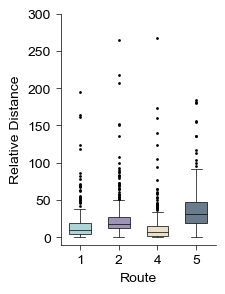

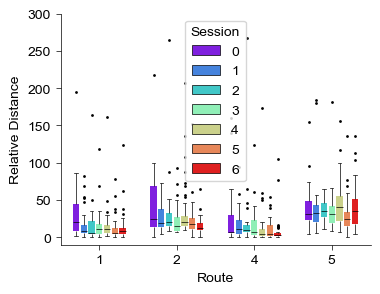

C:\Users\12454\AppData\Local\Temp\ipykernel_15516\783129514.py:276: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


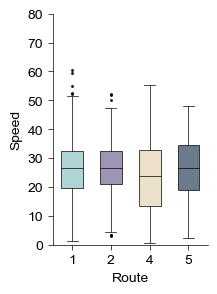

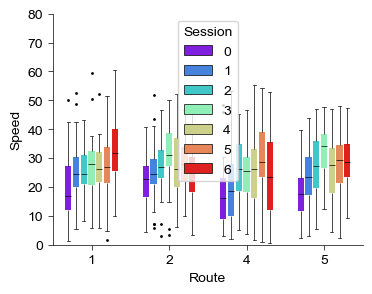

F_onewayResult(statistic=27.959015964353245, pvalue=2.1701605375648498e-17)
F_onewayResult(statistic=2.758481202269347, pvalue=0.04118044973027536)


In [3]:
@jit(nopython=True)
def _calc_shortest_idx(src_neural_traj, targ_neural_traj):
    idx = np.zeros(src_neural_traj.shape[1], dtype=np.int64)
    val = np.zeros(src_neural_traj.shape[1])
    for i in range(src_neural_traj.shape[1]):
        corrs = np.zeros(targ_neural_traj.shape[1])
        for j in range(targ_neural_traj.shape[1]):
            corrs[j] = np.corrcoef(src_neural_traj[:, i], targ_neural_traj[:, j])[0, 1]
        
        corrs[np.where(np.isnan(corrs))[0]] = -1
        idx[i] = np.argmax(corrs)
        val[i] = np.max(corrs)
    return idx, val
        
def mapping_neural_activity(mouse, route: int, targ_route=0, session = 6):
    idx = np.where(f2['MiceID'] == mouse)[0][session]
    with open(f2['Trace File'][idx], 'rb') as handle:
        trace = pickle.load(handle)
    
    (
        neural_traj,
        pos_traj,
        time_traj,
        route_traj,
        lap_traj,
        speed_traj,
        
        perfect_traj
    ) = get_neural_traj(trace)
    session_traj = np.repeat(session, neural_traj.shape[1])
    
    targ_idx = np.where(route_traj == targ_route)[0]
    targ_neural_traj = neural_traj[:, targ_idx]
    targ_pos_traj = pos_traj[targ_idx]
    
    src_idx = np.where(route_traj == route)[0]
    src_neural_traj = neural_traj[:, src_idx]
    src_pos_traj = pos_traj[src_idx]
    
    idx, corr_val = _calc_shortest_idx(src_neural_traj, targ_neural_traj)
    
    src_pos_traj_mapped = targ_pos_traj[idx]
    
    return src_pos_traj, targ_pos_traj, idx, corr_val, lap_traj[src_idx], speed_traj[src_idx], src_neural_traj
    
def process_(mouse, route, session, loss_thre: float = 10, corr_thre = 0.3):
    print(f"Start Mapping Neural Activity for {mouse}, Route {route}, S{session}. ~ 30s required.")
    t0 = time.time()
    src_pos_traj, targ_pos_traj, idx, corr_val, lap, speed_traj, neural_traj = mapping_neural_activity(mouse, route, session=session)
    print(f"  {time.time()-t0:.3f}s used. Start Visualization.\n")
    
    D = GetDMatrices(1, 48)
    loss = np.array([D[src_pos_traj[i], targ_pos_traj[idx][i]] for i in range(src_pos_traj.shape[0])])
    
    beg = np.concatenate([[0], np.where(np.ediff1d(lap)!=0)[0]+1])
    end = np.concatenate([beg[1:], [lap.shape[0]]])
    
    speed = np.zeros(beg.shape[0])
    corr = np.zeros(beg.shape[0])
    distances = np.zeros(beg.shape[0])
    times = np.zeros(beg.shape[0])
    
    pos = []

    for i in range(len(beg)):
        x, y = src_pos_traj % 48, src_pos_traj // 48
        dx, dy = np.ediff1d(x), np.ediff1d(y)
        dl = np.sqrt(dx**2 + dy**2)
        cum_dis = np.cumsum(dl)
        
        _converge_idx = np.where(
            (loss[beg[i]:end[i]] <= loss_thre) &
            (corr_val[beg[i]:end[i]] >= corr_thre)
        )[0]
        
        if _converge_idx.shape[0] == 0:
            speed[i], corr[i], distances[i] = np.nan, np.nan, np.nan
            times[i] = np.nan
            pos.append(np.array([]))
            continue
                
        # Whenever 3 continue point satisfy the criteria, we identify that the map is converged.
        is_converge = False
        init_pos = _converge_idx[0]
        for j in range(len(_converge_idx)-2):
            if _converge_idx[j] + 2 == _converge_idx[j+2]:
                init_pos = _converge_idx[j]
                is_converge = True
                break
        
        if is_converge:
            speed[i] = speed_traj[beg[i] + init_pos]
            corr[i] = corr_val[beg[i] + init_pos]
            distances[i] = cum_dis[init_pos]
            times[i] = 0.5 + 0.1*init_pos
            pos.append(targ_pos_traj[idx][beg[i]:beg[i] + init_pos])
        else:
            speed[i], corr[i], distances[i] = np.nan, np.nan, np.nan
            times[i] = np.nan
            pos.append(np.array([]))
        
    if len(pos) >= 2:
        pos = np.concatenate(pos)
    elif len(pos) == 1:
        pos = pos[0]
    else:
        pos = np.array([])
        
    pos = pos[np.where(np.isnan(pos) == False)[0]].astype(np.int64)
    
    rates_count = scipy.stats.binned_statistic(
        pos+1,
        np.ones(pos.shape[0]),
        statistic='sum',
        bins=2304,
        range=[0, 2304+1e-8]
    )[0]
    bg_count = scipy.stats.binned_statistic(
        targ_pos_traj+1,
        np.ones(targ_pos_traj.shape[0]),
        statistic='count',
        bins=2304,
        range=[0, 2304+1e-8]
    )[0]
    bg_count[bg_count == 0] = 1e-8
    rates = rates_count / bg_count
    
    rates_count2 = scipy.stats.binned_statistic(
        S2F[pos],
        np.ones(pos.shape[0]),
        statistic='sum',
        bins=144,
        range=[0, 144+1e-8]
    )[0]
    bg_count2 = scipy.stats.binned_statistic(
        S2F[targ_pos_traj],
        np.ones(targ_pos_traj.shape[0]),
        statistic='count',
        bins=144,
        range=[0, 144+1e-8]
    )[0]
    bg_count2[bg_count2 == 0] = 1e-8
    rate2s = rates_count2 / bg_count2
    
    save_data = {
        "speed_traj": speed_traj,
        "neural_traj": neural_traj,
        "targ_pos_traj": targ_pos_traj,
        "idx": idx,
        "lap_traj": lap,
        "session_traj": np.repeat(session, speed_traj.shape[0]),
        "error_mapping_distribution": rates,
        "error_mapping_distribution2": rate2s
    }
    
    return speed, corr, distances, pos, times, save_data

mkdir(join(loc, "Mapping Data"))
if exists(join(figdata, f"{code_id}.pkl")) == False:
    Data = {
        "MiceID":[],
        "Session": [],
        "Route": [],
        "Corr": [],
        "Relative Distance": [],
        "Speed": [],
        "Time": []
    }
    
    PriorInitData = {
        "MiceID":[],
        "Session": [],
        "Route": [],
        "Position": []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        for route in range(1, 7):
            for session in range(7):
                speed, corr, distances, pos, times, save_data = process_(mouse, route, session=session)
                Data['MiceID'].append(np.repeat(mouse, speed.shape[0]))
                Data['Session'].append(np.repeat(session, speed.shape[0]))
                Data['Route'].append(np.repeat(route, speed.shape[0]))
                Data['Corr'].append(corr)
                Data['Relative Distance'].append(distances)
                Data['Speed'].append(speed)
                Data['Time'].append(times)
                
                PriorInitData['MiceID'].append(np.repeat(mouse, pos.shape[0]))
                PriorInitData['Session'].append(np.repeat(session, pos.shape[0]))
                PriorInitData['Route'].append(np.repeat(route, pos.shape[0]))
                PriorInitData['Position'].append(pos)
                
                with open(join(loc, "Mapping Data", f"{mouse} R{route} S{session}.pkl"), 'wb') as f:
                    pickle.dump(save_data, f)
                    
    for k in Data.keys():
        Data[k] = np.concatenate(Data[k])
        
    for k in PriorInitData.keys():
        PriorInitData[k] = np.concatenate(PriorInitData[k])
        
    print(Data['Corr'].shape[0], PriorInitData['Position'].shape)
    
    with open(join(figdata, f"{code_id}.pkl"), 'wb') as f:
        pickle.dump(Data, f)
    
    D = pd.DataFrame(Data)
    D.to_excel(join(figdata, f"{code_id}.xlsx"), index=False)
        
    with open(join(figdata, f"{code_id} [Pos].pkl"), 'wb') as f:
        pickle.dump(PriorInitData, f)
    
    PriorInitD = pd.DataFrame(PriorInitData)
    PriorInitD.to_excel(join(figdata, f"{code_id} [Pos].xlsx"), index=False)
else:
    with open(join(figdata, f"{code_id}.pkl"), 'rb') as handle:
        Data = pickle.load(handle)
        
    with open(join(figdata, f"{code_id} [Pos].pkl"), 'rb') as f:
        PriorInitData = pickle.load(f)

idx = np.where(np.isin(Data['Route'], [1, 2, 4, 5]))[0]
SubData = SubDict(Data, Data.keys(), idx)
fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(
    plt.axes(), 
    close_spines=['top', 'right'], 
    ifxticks=True, ifyticks=True
)
sns.boxplot(
    x="Route",
    y="Relative Distance",
    data=SubData,
    palette=[DSPPalette[i] for i in [1, 2, 4, 5]],
    linecolor='k',
    linewidth=0.5,
    fliersize=1,
    width=0.7,
    gap=0.2
)
ax.set_ylim(-10,300)
plt.savefig(join(loc, "Relative Distances.png"), dpi=600)
plt.savefig(join(loc, "Relative Distances.svg"), dpi=600)
plt.show()

fig = plt.figure(figsize=(4, 3))
ax = Clear_Axes(
    plt.axes(), 
    close_spines=['top', 'right'], 
    ifxticks=True, ifyticks=True
)
box = sns.boxplot(
    x="Route",
    y="Relative Distance",
    data=SubData,
    hue="Session",
    palette='rainbow',
    linecolor='k',
    linewidth=0.5,
    fliersize=1,
    width=0.7,
    gap=0.2
)
for b in box.patches:
    b.set_linewidth(0)
ax.set_ylim(-10,300)
plt.show()

fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(
    plt.axes(), 
    close_spines=['top', 'right'], 
    ifxticks=True, ifyticks=True 
)
sns.boxplot(
    x="Route",
    y="Speed",
    data=SubData,
    palette=[DSPPalette[i] for i in [1, 2, 4, 5]],
    linecolor='k',
    linewidth=0.5,
    fliersize=1,
    width=0.7,
    gap=0.2
)
ax.set_ylim(0, 80)
plt.savefig(join(loc, "Speed.png"), dpi=600)
plt.savefig(join(loc, "Speed.svg"), dpi=600)
plt.show()

fig = plt.figure(figsize=(4, 3))
ax = Clear_Axes(
    plt.axes(), 
    close_spines=['top', 'right'], 
    ifxticks=True, ifyticks=True 
)
box = sns.boxplot(
    x="Route",
    y="Speed",
    data=SubData,
    hue="Session",
    palette="rainbow",
    linecolor='k',
    linewidth=0.5,
    fliersize=1,
    width=0.7,
    gap=0.2
)
for b in box.patches:
    b.set_linewidth(0)
ax.set_ylim(0, 80)
plt.show()

print(f_oneway(*[SubData['Relative Distance'][
    (SubData['Route'] == i)&(np.isnan(SubData['Relative Distance']) == False)
    ] for i in [1, 2, 4, 5]
]))
print(f_oneway(*[SubData['Speed'][
    (SubData['Route'] == i)&(np.isnan(SubData['Speed']) == False)
    ] for i in [1, 2, 4, 5]
]))

# Rate

(18648,)


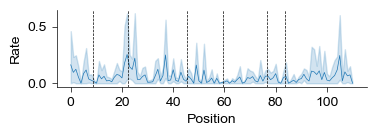

In [6]:
from mylib.statistic_test import *

def convert_rate_map_to_values(rate_map):
    #bins = np.concatenate([Father2SonGraph[i] for i in CP_DSP[0]])-1
    bins = CP_DSP[0]-1
    #Ms = SmoothMatrix(1, 1)
    #rate_map = np.dot(rate_map, Ms.T)
    
    #D = GetDMatrices(1, 12)
    
    return rate_map[bins], np.arange(CP_DSP[0].shape[0])#D[bins, 0]

if exists(join(figdata, f"{code_id} [Rate].pkl")) == False:

    RateData = {
        "MiceID":[],
        "Session": [],
        "Route": [],
        "Position": [],
        "Rate": []
    }

    for mouse in [10212, 10224, 10227, 10232]:
        for route in range(1, 7):
            for session in range(7):
                with open(join(loc, "Mapping Data", f"{mouse} R{route} S{session}.pkl"), 'rb') as f:
                    save_data = pickle.load(f)
                rate_map, linear_pos = convert_rate_map_to_values(save_data['error_mapping_distribution2'])
                RateData['MiceID'].append(np.repeat(mouse, rate_map.shape[0]))
                RateData['Session'].append(np.repeat(session, rate_map.shape[0]))
                RateData['Route'].append(np.repeat(route, rate_map.shape[0]))
                RateData['Position'].append(linear_pos)
                RateData['Rate'].append(rate_map)
                
    for k in RateData.keys():
        RateData[k] = np.concatenate(RateData[k])
        
    with open(join(figdata, f"{code_id} [Rate].pkl"), 'wb') as f:
        pickle.dump(RateData, f)
        
    RateD = pd.DataFrame(RateData)
    RateD.to_excel(join(figdata, f"{code_id} [Rate].xlsx"), index=False)
else:    
    with open(join(figdata, f"{code_id} [Rate].pkl"), 'rb') as f:
        RateData = pickle.load(f)
        
    print(RateData['Rate'].shape)

#RateData['Position'] = RateData['Position'] / np.max(RateData['Position']) * 55

fig = plt.figure(figsize=(4, 1))
idx = np.where((RateData['Session'] < 1)&(RateData['Route'] == 1))[0]
SubData = SubDict(RateData, RateData.keys(), idx)
ax = Clear_Axes(
    plt.axes(), 
    close_spines=['top', 'right'], 
    ifxticks=True, ifyticks=True
)
sns.lineplot(
    x="Position",
    y="Rate",
    data=SubData,
    #hue="Session",
    #palette=[DSPPalette[i] for i in [1, 2, 3, 4, 5, 6]],
    linewidth=0.5,
    ax=ax
)
for d in [
    len(np.setdiff1d(CP_DSP[0], CP_DSP[i]))-0.5 for i in range(1, 7)
]:
    ax.axvline(d, color='k', linewidth=0.5, ls='--')

# Lapwise Rate Map & Lapwise PVC

        E:\Data\FinalResults\Dsp\0855 - Mapping Initialization Phase is already existed!


100%|██████████| 52/52 [00:00<00:00, 88.65it/s]
C:\Users\12454\AppData\Local\Temp\ipykernel_10908\1284752322.py:61: RuntimeWarning: Mean of empty slice
  ref_map0[:, i] = np.nanmean(neural_traj[:, idx], axis=1)
C:\Users\12454\AppData\Local\Temp\ipykernel_10908\1284752322.py:63: RuntimeWarning: Mean of empty slice
  ref_map1[:, i] = np.nanmean(neural_traj[:, idx], axis=1)
 59%|█████▉    | 6528/11050 [00:00<00:00, 9458.42it/s] e:\Anaconda\envs\maze\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
e:\Anaconda\envs\maze\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 16259/16259 [00:01<00:00, 11679.63it/s]


(940926,) (1170,)
574420
Route 1
  Mean: 31.407823669878436, STD: 22.555028230242556, Max: 177.226231156957, Min: 0.37879196033799306, Median: 27.689387822911918, df: 210

Route 2
  Mean: 55.95772021255966, STD: 26.440276871235326, Max: 167.04014376040692, Min: 2.7616110100350424, Median: 55.41458777434709, df: 182

Route 4
  Mean: 28.554310391515866, STD: 22.193192960829116, Max: 108.24938316214968, Min: 0.44567647359949486, Median: 23.227000021465425, df: 184

Route 5
  Mean: 83.38193561601499, STD: 49.355916489326134, Max: 395.8782205370397, Min: 1.5679832101201867, Median: 78.03385896553978, df: 209

Route 6
  Mean: 34.55860421837553, STD: 25.130814515683873, Max: 159.74011896255828, Min: 7.541962039454826, Median: 26.849748479833547, df: 54

Distance: F_onewayResult(statistic=98.82177475674374, pvalue=6.316842709778141e-69)
Speed: F_onewayResult(statistic=5.276838460991848, pvalue=0.0003358733057769326)


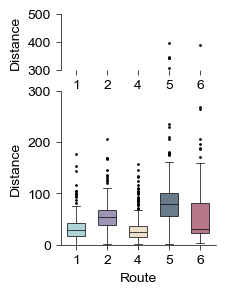

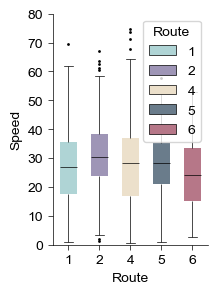

"\nDSPPalette\nfor r in range(1, 7):\n    fig = plt.figure(figsize=(4, 2))\n    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)\n    SubData = SubDict(PData, PData.keys(), np.where((PData['Route'] == r)&(PData['Type'] == 'Data'))[0])\n    idx = np.where((np.array(Labels['Route']) == r)&(np.array(Labels['Type']) == 'Data'))[0]\n    sns.lineplot(\n        x='Position',\n        y='PVC',\n        data=SubData,\n        hue='Session',\n        palette='rainbow', # Black\n        legend=False,\n        linewidth=0.3\n    )\n    SubData = SubDict(PData, PData.keys(), np.where((PData['Route'] == r)&(PData['Type'] != 'Data'))[0])\n    sns.lineplot(\n        x='Position',\n        y='PVC',\n        data=SubData,\n        hue='Type',\n        palette=['#0a1a2e'], # Black\n        legend=False,\n        linewidth=0.5,\n        ax=ax\n    )\n    plt.show()\n"

In [31]:
from mylib.statistic_test import *
from mazepy.datastruc.neuact import NeuralTrajectory, SpikeTrain
from mazepy.datastruc.variables import VariableBin
from mylib.calcium.dsp_ms import classify_lap
from mazepy.basic._time_sync import _coordinate_recording_time

code_id = "0855 - Mapping Initialization Phase"
loc = os.path.join(figpath, "Dsp", code_id)
mkdir(loc)

def get_lapwise_ratemap(trace: dict):    
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx)
    smoothed_map = np.zeros((trace['n_neuron'], 2304, beg_idx.shape[0]), dtype = np.float64)
    
    for i in range(beg_idx.shape[0]):
        
        spike_idx = np.where(
            (trace['ms_time'] >= beg_time[i]) & (trace['ms_time'] <= end_time[i]) &
            (np.isnan(trace['spike_nodes_original']) == False)
        )[0]
        
        spike_nodes = trace['spike_nodes_original'][spike_idx].astype(np.int64)-1
        Spikes = trace['Spikes_original'][:, spike_idx]
        
        spike_train = SpikeTrain(
            activity=Spikes,
            time=trace['ms_time'][spike_idx],
            variable=VariableBin(spike_nodes),
        )
        
        rate_map = spike_train.calc_tuning_curve(2304, t_interv_limits=100)
        smoothed_map[:, :, i] = rate_map.to_array() #@ trace['Ms'].T
    
    return smoothed_map

def _generate_t_distribution(PVCs):
    return np.percentile(PVCs, 2.5)

def lapwise_pvc(trace: dict, is_return_pvc: bool = False, is_shuffle: bool = False):
    (
        neural_traj,
        pos_traj,
        time_traj,
        route_traj,
        lap_traj,
        speed_traj,
        cumlen_traj,
        perfect_traj
    ) = get_neural_traj(trace)
    
    n_lap = int(np.max(lap_traj))
    
    # Get reference neural trajectory
    old_pos_traj = S2F[pos_traj]-1
    ref_map0 = np.zeros((neural_traj.shape[0], 144))
    ref_map1 = np.zeros((neural_traj.shape[0], 144))
    for i in range(144):
        idx = np.where((old_pos_traj == i)&(route_traj == 0)&(lap_traj <= n_lap/2))[0]
        ref_map0[:, i] = np.nanmean(neural_traj[:, idx], axis=1)
        idx = np.where((old_pos_traj == i)&(route_traj == 0)&(lap_traj > n_lap/2))[0]
        ref_map1[:, i] = np.nanmean(neural_traj[:, idx], axis=1)
    
    init_ps = [0, 0, 0, 0, 2, 3, 4]
    bins = [
        CP_DSP[r][init_ps[r]:]-1 for r in range(7)
    ]
    
    if is_shuffle:
        neural_traj = neural_traj[:, np.random.permutation(neural_traj.shape[1])]
    
    pvc_traj = np.zeros(perfect_traj.shape[0])
    for i in tqdm(range(perfect_traj.shape[0])):
        ref_map = ref_map0 if lap_traj[i] <= n_lap/2 else ref_map1
        
        r = route_traj[i]
        p = old_pos_traj[i]
        pvc_traj[i] = np.corrcoef(
            ref_map[:, p],
            neural_traj[:, i]
        )[0, 1]
        
    if is_shuffle:
        return (
            neural_traj,
            pos_traj,
            time_traj,
            route_traj,
            lap_traj,
            speed_traj,
            cumlen_traj,
            perfect_traj,
            pvc_traj
        )
    
    # Get t-distribution
    CI_thres = np.zeros(144)
    for b in range(144):
        idx = np.where((route_traj == 0)&(old_pos_traj == b))[0]
        
        if len(idx) < 5:
            CI_thres[b] = np.nan
        else:
            CI_thres[b] = _generate_t_distribution(pvc_traj[idx])
            
    res_traj = pvc_traj - CI_thres[old_pos_traj]
    
    lap_begs = np.concatenate([[0], np.where(np.ediff1d(lap_traj) != 0)[0]+1])
    lap_ends = np.concatenate([lap_begs[1:], [pvc_traj.shape[0]]])
    
    lap, route, distances, times, speed, pos, is_perfect = [], [], [], [], [], [], []
    for n in tqdm(range(lap_begs.shape[0])):
        if route_traj[lap_begs[n]] == 0:
            continue
        
        l, r = lap_begs[n], lap_ends[n]
        transition_idx = np.where(res_traj[l:r] >= 0)[0]
        if len(transition_idx) == 0:
            transition_idx = np.inf
        else:
            # Test if there is 
            continuous1 = np.where(np.ediff1d(transition_idx) == 1)[0]
            if continuous1.shape[0] > 0:
                transition_idx = transition_idx[continuous1[0]]
            else:
                transition_idx = np.inf
                continue
            
            lap.append(n)
            route.append(route_traj[l])
            distances.append(cumlen_traj[l+transition_idx])
            speed.append(speed_traj[l+transition_idx])
            times.append(time_traj[l+transition_idx])
            pos.append(pos_traj[l+transition_idx])
            is_perfect.append(trace['is_perfect'][n])
    
    if is_return_pvc:
        return (
            np.array(lap, np.int64), 
            np.array(route, np.int64), 
            np.array(distances, np.float64), 
            np.array(times, np.float64), 
            np.array(speed, np.float64),
            np.array(pos, np.int64),
            np.array(is_perfect, np.int64),
            neural_traj,
            pos_traj,
            time_traj,
            route_traj,
            lap_traj,
            speed_traj,
            cumlen_traj,
            perfect_traj,
            pvc_traj,
            CI_thres
        )
    return (
        np.array(lap, np.int64), 
        np.array(route, np.int64), 
        np.array(distances, np.float64), 
        np.array(times, np.float64), 
        np.array(speed, np.float64),
        np.array(pos, np.int64),
        np.array(is_perfect, np.int64)
    )


@jit(nopython=False)
def _average_pvc(lap_beg, lap_end, pvc, pos):
    avg_pvc = np.full((lap_beg.shape[0], 110), np.nan)
    for i in range(len(lap_beg)):
        l, r = lap_beg[i], lap_end[i]
        for b in range(110):
            idx = np.where(pos[l:r] == b)[0]
            if idx.shape[0] != 0:
                avg_pvc[i, b] = np.nanmean(pvc[l:r][idx])
    return avg_pvc

if (
    exists(join(figdata, f"{code_id}  [lapwise pvc].pkl")) and 
    exists(join(figdata, f"{code_id} [Retrival Parameters].pkl"))
):
    with open(join(figdata, f"{code_id} [lapwise pvc].pkl"), 'rb') as f:
        Data = pickle.load(f)
        
    with open(join(figdata, f"{code_id} [Retrival Parameters].pkl"), 'rb') as f:
        RData = pickle.load(f)

    with open(join(figdata, f"{code_id} [lapwise pvc processed].pkl"), 'rb') as f:
        PData, Labels = pickle.load(f)
else:
    Data = {
        "MiceID": [],
        "Session": [],
        "Route": [],
        "Position": [],
        "PVC": [],
        "Lap": [],
        "Type": []
    }
    
    RData = {
        "MiceID": [],
        "Session": [],
        "Route": [],
        "Position": [],
        "Distance": [],
        "Speed": [],
        "Time": [],
        "IsPerfect": []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        file_idx = np.where(f2['MiceID'] == mouse)[0]
        for session in range(7):
            with open(f2['Trace File'][file_idx[session]], 'rb') as handle:
                trace = pickle.load(handle)
                
            (
                lap, 
                route, 
                distances, 
                times,
                speed,
                pos,
                is_perfect,
            
                neural_traj,
                pos_traj,
                time_traj,
                route_traj,
                lap_traj,
                speed_traj,
                cumlen_traj,
                perfect_traj,
                pvc_traj,
                CI_thres
            ) = lapwise_pvc(trace, is_return_pvc=True)
            
            Data['MiceID'].append(np.repeat(mouse, pos_traj.shape[0]))
            Data['Session'].append(np.repeat(session, pos_traj.shape[0]))
            Data['Route'].append(route_traj)
            Data['Position'].append(pos_traj)
            Data['PVC'].append(pvc_traj)
            Data['Lap'].append(lap_traj)
            Data['Type'].append(np.repeat('Data', lap_traj.shape[0]))
            
            RData['MiceID'].append(np.repeat(mouse, lap.shape[0]))
            RData['Session'].append(np.repeat(session, lap.shape[0]))
            RData['Route'].append(route)
            RData['Position'].append(pos)
            RData['Distance'].append(distances)
            RData['Speed'].append(speed)
            RData['Time'].append(times)
            RData['IsPerfect'].append(is_perfect)
            
            (
                neural_traj,
                pos_traj,
                time_traj,
                route_traj,
                lap_traj,
                speed_traj,
                cumlen_traj,
                perfect_traj,
                pvc_traj
            ) = lapwise_pvc(trace, is_shuffle=True)
            
            Data['MiceID'].append(np.repeat(mouse, pos_traj.shape[0]))
            Data['Session'].append(np.repeat(session, pos_traj.shape[0]))
            Data['Route'].append(route_traj)
            Data['Position'].append(pos_traj)
            Data['PVC'].append(pvc_traj)
            Data['Lap'].append(lap_traj)
            Data['Type'].append(np.repeat('Shuffle', lap_traj.shape[0]))
            
    for k in Data.keys():
        Data[k] = np.concatenate(Data[k])
        
    for k in RData.keys():
        RData[k] = np.concatenate(RData[k])
        
    print(Data['PVC'].shape, RData['Speed'].shape)
    
    with open(join(figdata, f"{code_id} [lapwise pvc].pkl"), 'wb') as f:
        pickle.dump(Data, f)
        
    with open(join(figdata, f"{code_id} [Retrival Parameters].pkl"), 'wb') as f:
        pickle.dump(RData, f)
    
    try:
        RD = pd.DataFrame(RData)
        RD.to_excel(join(figdata, f"{code_id} [Retrival Parameters].xlsx"), index=False)
        
        D = pd.DataFrame(Data)
        D.to_excel(join(figdata, f"{code_id} [lapwise pvc].xlsx"), index=False)
    except:
        pass
    
    PData = {}
    for k in Data.keys():
        PData[k] = []
        
    Labels = {
        "Route": [],
        "Session": [],
        "Type": [],
        "RoutePalette": [],
        "SessionPalette": []
    }
    session_colors = sns.color_palette("rainbow", 7)
        
    D = GetDMatrices(1, 48)
    Data['Position'] = (D[Data['Position'], 0] / np.nanmax(D + 1e-8) * 110) // 1
    
    lap_beg = np.concatenate([[0], np.where(np.ediff1d(Data['Lap']) != 0)[0]+1])
    lap_end = np.concatenate([lap_beg[1:], [Data['Lap'].shape[0]]])
    
    avg_pvc = _average_pvc(lap_beg, lap_end, Data['PVC'], Data['Position'])
    for i in range(len(lap_beg)):
        PData['MiceID'].append(np.repeat(Data['MiceID'][lap_beg[i]], 110))
        PData['Lap'].append(np.repeat(i, 110))
        PData['Route'].append(np.repeat(Data['Route'][lap_beg[i]], 110))
        PData['Position'].append(np.arange(110))
        PData['PVC'].append(avg_pvc[i])
        PData['Type'].append(np.repeat(Data['Type'][lap_beg[i]], 110))
        PData['Session'].append(np.repeat(Data['Session'][lap_beg[i]], 110))
        
        Labels['Route'].append(Data['Route'][lap_beg[i]])
        Labels['Session'].append(Data['Session'][lap_beg[i]])
        Labels['Type'].append(Data['Type'][lap_beg[i]])
        if Data['Type'][lap_beg[i]] == 'Data':
            Labels['RoutePalette'].append(DSPPalette[Data['Route'][lap_beg[i]]])
            Labels['SessionPalette'].append(session_colors[Data['Session'][lap_beg[i]]])
        else:
            Labels['RoutePalette'].append('#0a1a2e')
            Labels['SessionPalette'].append('#0a1a2e')
        
    for k in PData.keys():
        PData[k] = np.concatenate(PData[k])
    
    print(PData['Position'].shape[0])
        
    with open(join(figdata, f"{code_id} [lapwise pvc processed].pkl"), 'wb') as f:
        pickle.dump([PData, Labels], f)
        
D = GetDMatrices(1, 48)
for r in [1, 2, 4, 5, 6]:
    idx = np.where((RData['Route'] == r)&(RData['IsPerfect'] == 1))[0]
    print(f"Route {r}")
    print_estimator(RData['Distance'][idx], end='\n\n')

D = GetDMatrices(1, 48)
statdata = []
statdata_speed = []
for r in [1, 2, 4, 5, 6]:
    idx = np.where(RData['Route'] == r)[0]
    RData['Position'][idx] = (D[RData['Position'][idx], SP_DSP[r]-1] / np.nanmax(D + 1e-8) * 110) // 1 * 8
    idx = np.where((RData['Route'] == r)&(RData['IsPerfect'] == 1))[0]
    statdata.append(RData['Distance'][idx])
    statdata_speed.append(RData['Speed'][idx])

print(f"Distance: {f_oneway(*statdata)}")
print(f"Speed: {f_oneway(*statdata_speed)}")

fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(2, 3), gridspec_kw={'height_ratios': [0.8, 2.2]})
ax1 = Clear_Axes(axes[0], close_spines=['top', 'right', 'bottom'], ifxticks=True, ifyticks=True)
ax2 = Clear_Axes(axes[1], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
SubData = SubDict(RData, RData.keys(), np.where(np.isin(RData['Route'], [1, 2, 4, 5, 6]))[0])
sns.boxplot(
    x='Route',
    y='Distance',
    data=SubData,
    hue='Route',
    palette=[DSPPalette[i] for i in [1, 2, 4, 5, 6]],
    fliersize=1,
    gap=0.3,
    legend=False,
    linecolor='k',
    linewidth=0.5,
    ax=ax1
)
ax1.set_ylim(300, 500)
sns.boxplot(
    x='Route',
    y='Distance',
    data=SubData,
    hue='Route',
    palette=[DSPPalette[i] for i in [1, 2, 4, 5, 6]],
    fliersize=1,
    gap=0.3,
    legend=False,
    linecolor='k',
    linewidth=0.5,
    ax=ax2
)
ax2.set_ylim(0, 300)
plt.savefig(join(loc, "Retrival Distance.png"), dpi=600)
plt.savefig(join(loc, "Retrival Distance.svg"), dpi=600)
plt.show()
"""

fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
SubData = SubDict(RData, RData.keys(), np.where(np.isin(RData['Route'], [1, 2, 4, 5]))[0])
box = sns.boxplot(
    x='Route',
    y='Time',
    data=SubData,
    hue='Session',
    palette='rainbow',
    linecolor='k',
    linewidth=0.5,
    fliersize=1,
    width=0.7,
    gap=0.2,
    dodge=True
)
for b in box.patches:
    b.set_linewidth(0)
plt.show()
"""
fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
SubData = SubDict(RData, RData.keys(), np.where(np.isin(RData['Route'], [1, 2, 4, 5, 6]))[0])
box = sns.boxplot(
    x='Route',
    y='Speed',
    data=SubData,
    hue='Route',
    palette=[DSPPalette[i] for i in [1, 2, 4, 5, 6]],
    linecolor='k',
    linewidth=0.5,
    fliersize=1,
    width=0.8,
    gap=0.3
)
for b in box.patches:
    b.set_linewidth(0)
ax.set_ylim(0, 80)
plt.savefig
plt.show()

"""
DSPPalette
for r in range(1, 7):
    fig = plt.figure(figsize=(4, 2))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    SubData = SubDict(PData, PData.keys(), np.where((PData['Route'] == r)&(PData['Type'] == 'Data'))[0])
    idx = np.where((np.array(Labels['Route']) == r)&(np.array(Labels['Type']) == 'Data'))[0]
    sns.lineplot(
        x='Position',
        y='PVC',
        data=SubData,
        hue='Session',
        palette='rainbow', # Black
        legend=False,
        linewidth=0.3
    )
    SubData = SubDict(PData, PData.keys(), np.where((PData['Route'] == r)&(PData['Type'] != 'Data'))[0])
    sns.lineplot(
        x='Position',
        y='PVC',
        data=SubData,
        hue='Type',
        palette=['#0a1a2e'], # Black
        legend=False,
        linewidth=0.5,
        ax=ax
    )
    plt.show()
"""

# Visualize Transition Moment

In [ ]:
with open(f2['Trace File'][34], 'rb') as handle:
    trace = pickle.load(handle)

(
    lap, 
    route, 
    distances, 
    times,
    speed,
    pos,
    is_perfect,
            
    neural_traj,
    pos_traj,
    time_traj,
    route_traj,
    lap_traj,
    speed_traj,
    cumlen_traj,
    perfect_traj,
    pvc_traj,
    CI_thres
) = lapwise_pvc(trace, is_return_pvc=True)

(
    neural_traj_sf,
    pos_traj_sf,
    time_traj_sf,
    route_traj_sf,
    lap_traj_sf,
    speed_traj_sf,
    cumlen_traj_sf,
    perfect_traj_sf,
    pvc_traj_sf
) = lapwise_pvc(trace, is_shuffle=True)

idx = np.where(route_traj == 0)[0]
old_pos_traj = S2F[pos_traj]-1

beg = np.concatenate([[0], np.where(np.ediff1d(lap_traj)!=0)[0]+1])
end = np.concatenate([np.where(np.ediff1d(lap_traj)!=0)[0]+1, [len(lap_traj)]])

beg_sf = np.concatenate([[0], np.where(np.ediff1d(lap_traj_sf)!=0)[0]+1])
end_sf = np.concatenate([np.where(np.ediff1d(lap_traj_sf)!=0)[0]+1, [len(lap_traj_sf)]])

100%|██████████| 130/130 [00:02<00:00, 62.81it/s]
C:\Users\12454\AppData\Local\Temp\ipykernel_10908\1284752322.py:63: RuntimeWarning: Mean of empty slice
  ref_map1[:, i] = np.nanmean(neural_traj[:, idx], axis=1)
C:\Users\12454\AppData\Local\Temp\ipykernel_10908\1284752322.py:61: RuntimeWarning: Mean of empty slice
  ref_map0[:, i] = np.nanmean(neural_traj[:, idx], axis=1)
100%|██████████| 130/130 [00:00<00:00, 64911.85it/s]


ValueError: too many values to unpack (expected 16)

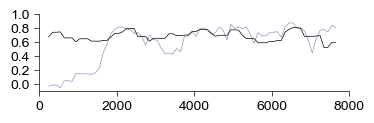

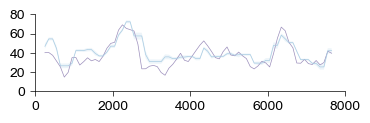

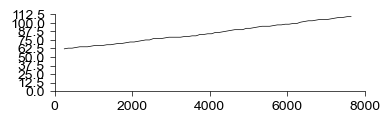

In [34]:
n = np.where((route_traj[beg] == 2)&(perfect_traj[beg] == 1))[0][0]
fig = plt.figure(figsize=(4, 1))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax.plot(
    time_traj[beg[n]:end[n]],
    pvc_traj[beg[n]:end[n]],
    linewidth=0.5,
    color=DSPPalette[2]
)
ax.plot(
    time_traj[beg[n]:end[n]],
    CI_thres[old_pos_traj[beg[n]:end[n]]],
    linewidth=0.5,
    color='Black'
)
ax.set_ylim(-0.1, 1)
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_xlim(0, 8000)
plt.savefig(join(loc, "[Example] PVC.png"), dpi=600)
plt.savefig(join(loc, "[Example] PVC.svg"), dpi=600)
plt.show()

#
fig = plt.figure(figsize=(4, 1))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax.plot(
    time_traj[beg[n]:end[n]],
    speed_traj[beg[n]:end[n]],
    linewidth=0.5,
    color=DSPPalette[2]
)
x_ctrl = []
s_ctrl = []
for i, p in enumerate(old_pos_traj[beg[n]:end[n]]):
    idx = np.where((route_traj == 0)&(old_pos_traj == p))[0]
    x_ctrl.append(np.repeat(time_traj[beg[n]:end[n]][i], len(idx)))
    s_ctrl.append(speed_traj[idx])
    
x_ctrl = np.concatenate(x_ctrl)
s_ctrl = np.concatenate(s_ctrl)
    
sns.lineplot(
    x=x_ctrl,
    y=s_ctrl,
    hue=np.ones(len(x_ctrl)),
    palette=[DSPPalette[0]],
    linewidth=0.5,
    err_kws={"edgecolor": None},
    ax=ax,
    legend=False
)
ax.set_ylim(0, 80)
ax.set_yticks(np.linspace(0, 80, 5))
ax.set_xlim(0, 8000)
plt.savefig(join(loc, "[Example] Speed.png"), dpi=600)
plt.savefig(join(loc, "[Example] Speed.svg"), dpi=600)
plt.show()

reorder_pos = np.zeros(pos_traj.shape[0])
for i in range(pos_traj.shape[0]):
    reorder_pos[i] = NRG[1][old_pos_traj[i]+1]

fig = plt.figure(figsize=(4, 1))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax.plot(
    time_traj[beg[n]:end[n]],
    reorder_pos[beg[n]:end[n]],
    linewidth=0.5,
    color='Black'
)
ax.set_ylim(0, 111)
ax.set_yticks(np.linspace(0, 112.5, 10))
ax.set_xlim(0, 8000)
plt.savefig(join(loc, "[Example] Position.png"), dpi=600)
plt.savefig(join(loc, "[Example] Position.svg"), dpi=600)
plt.show()